In [ ]:
!pip install keras-tuner

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1_l2, l1
import keras_tuner as kt
from google.colab.patches import cv2_imshow
from google.colab import drive
import tensorflow as tf

In [ ]:
# Montar drive y definir ruta
drive.mount('/content/drive')
dataPath='/content/drive/MyDrive/train'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def processingImages(target_size=(128, 128), augmentations=25):
    images = []
    labels = []
    class_names = os.listdir(dataPath)

    # Definir el generador de data augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,          # Rango de rotación
        width_shift_range=0.2,      # Rango de desplazamiento horizontal
        height_shift_range=0.2,     # Rango de desplazamiento vertical
        shear_range=0.2,            # Rango de cizallamiento
        zoom_range=0.2,             # Rango de zoom
        horizontal_flip=True,       # Inversión horizontal
        fill_mode='nearest',        # Modo de relleno
        brightness_range=[0.5, 1.5] # Rango de brillo
    )

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dataPath, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=target_size) # Cargar y redimensionar la imagen
            img_array = img_to_array(img)                     # Convertir la imagen a un array
            img_array = np.expand_dims(img_array, 0)          # Expandir dimensiones para el generador

            # Generar múltiples imágenes augmentadas
            i = 0
            for batch in datagen.flow(img_array, batch_size=1):
                images.append(batch[0])
                labels.append(label)
                i += 1
                if i >= augmentations:  # Generar 'augmentations' imágenes por imagen original
                    break

    images = np.array(images)
    labels = np.array(labels)

    return images, labels, class_names

In [ ]:
# Preprocesar y obtener las imágenes y etiquetas
images, labels, class_names = processingImages()

# Normalización
images = images.astype('float32') / 255.0

# Codificación one-hot de las etiquetas
labels = to_categorical(labels, num_classes=len(class_names))

# División del dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=40)

# Resumen de la información procesada
print(f'Total de imágenes: {len(images)}')
print(f'Total de clases: {len(class_names)}')
print(f'Dim de las imágenes: {images.shape}')
print(f'Dim de las etiquetas: {labels.shape}')

Total de imágenes: 11200
Total de clases: 8
Dim de las imágenes: (11200, 128, 128, 3)
Dim de las etiquetas: (11200, 8)


In [ ]:
print(class_names)

['camiseta_amarilla', 'camiseta_azul', 'camiseta_blanca', 'camiseta_roja', 'vestido_rojo', 'vestido_azul', 'vestido_amarillo', 'vestido_blanco']


In [ ]:
# Función para seleccionar el regularizador
def get_regularizer(hp):
    reg_type = hp.Choice('regularizer', ['l2', 'l1_l2'])
    if reg_type == 'l2':
        return l2(0.01)
    else:
        return l1_l2(l1=0.01, l2=0.01)

# Definir la función para construir el modelo
def build_model(hp, model_type):
    reg = get_regularizer(hp)
    if model_type == 'custom_cnn':
        kernel_size = hp.Choice('kernel_size', [3, 5])
        pool_size = hp.Choice('pool_size', [2, 3])

        model = Sequential([
            Conv2D(16, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=reg, input_shape=(128, 128, 3)),
            Conv2D(16, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=reg),
            BatchNormalization(),
            MaxPooling2D(pool_size=(pool_size, pool_size)),
            Dropout(hp.Float('dropout_rate', 0.3, 0.5, step=0.1)),

            Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=reg),
            Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=reg),
            BatchNormalization(),
            MaxPooling2D(pool_size=(pool_size, pool_size)),
            Dropout(hp.Float('dropout_rate', 0.3, 0.5, step=0.1)),

            Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg),
            Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg),
            BatchNormalization(),
            MaxPooling2D(pool_size=(pool_size, pool_size)),
            Dropout(hp.Float('dropout_rate', 0.3, 0.5, step=0.1)),

            Flatten(),
            Dense(64, activation='relu'),  # Reducir tamaño de la capa densa
            Dropout(0.5),
            Dense(len(class_names), activation='softmax')
        ])

    elif model_type == 'cnn_with_regularization':
        pool_size = hp.Choice('pool_size', [2, 3])

        model = Sequential([
            Conv2D(16, (3, 3), activation='relu', kernel_regularizer=reg, input_shape=(128, 128, 3)),
            MaxPooling2D(pool_size=(pool_size, pool_size)),
            Dropout(hp.Float('dropout_rate', 0.25, 0.5, step=0.1)),
            Conv2D(32, (3, 3), activation='relu', kernel_regularizer=reg),
            MaxPooling2D(pool_size=(pool_size, pool_size)),
            Dropout(hp.Float('dropout_rate', 0.25, 0.5, step=0.1)),
            Flatten(),
            Dense(64, activation='relu', kernel_regularizer=reg),  # Reducir tamaño de la capa densa
            Dropout(0.5),
            Dense(len(class_names), activation='softmax')
        ])

    elif model_type == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
        base_model.trainable = False  # Congelar el modelo base

        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(64, activation='relu')(x)  # Reducir tamaño de la capa densa
        x = Dropout(hp.Float('dropout_rate', 0.3, 0.5, step=0.1))(x)
        predictions = Dense(len(class_names), activation='softmax')(x)

        model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Graficar la historia del mejor modelo
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [ ]:
# Definir los tipos de modelo a evaluar
model_types = ['custom_cnn']

# Ejecutar la búsqueda de hiperparámetros para cada tipo de modelo y almacenar el mejor modelo
best_model = None
best_model_name = None
best_acc = 0.0
best_hp = None
best_history = None

history_custom = None
history_cnnWithReg = None
history_ResNet50 = None

for model_type in model_types:
    print(f"Buscando el mejor modelo para: {model_type}")
    tuner = kt.RandomSearch(
        lambda hp: build_model(hp, model_type=model_type),
        objective='val_accuracy',
        max_trials=5,
        executions_per_trial=1,
        directory='my_dir',
        project_name=f'cnn_tuning_{model_type}'
    )

    tuner.search_space_summary()

    tuner.search(X_train, y_train, epochs=15, validation_split=0.1)

    # Obtener los mejores hiperparámetros
    best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

    # Crear y entrenar el modelo con los mejores hiperparámetros
    model = build_model(best_hyperparameters, model_type=model_type)
    history = model.fit(X_train, y_train, epochs=30, validation_split=0.1)

    if model_type == 'custom_cnn':
      history_custom = history
    elif model_type == 'cnn_with_regularization':
      history_cnnWithReg = history
    elif model_type == 'resnet50':
      history_ResNet50 = history

    # Evaluar el modelo en el conjunto de validación
    val_acc = max(history.history['val_accuracy'])
    print(f"Mejor precisión de validación para {model_type}: {val_acc}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model
        best_hp = best_hyperparameters
        best_history = history
        best_model_name = model_type

print(f"El mejor modelo es {best_model_name}")

Trial 5 Complete [00h 02m 28s]
val_accuracy: 0.5680803656578064

Best val_accuracy So Far: 0.8805803656578064
Total elapsed time: 00h 11m 55s
Epoch 1/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.1467 - loss: 4.2441 - val_accuracy: 0.1339 - val_loss: 5.3937
Epoch 2/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.2261 - loss: 3.5018 - val_accuracy: 0.1708 - val_loss: 4.7302
Epoch 3/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.2668 - loss: 3.2667 - val_accuracy: 0.2857 - val_loss: 3.3554
Epoch 4/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3233 - loss: 3.0577 - val_accuracy: 0.3996 - val_loss: 2.8369
Epoch 5/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.4069 - loss: 2.7994 - val_accuracy: 0.5692 - val_loss: 2.4738
Epoch 6/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4853 - loss: 2.5201 - val_accuracy: 0.5625 - val_loss: 2.5311
Epoch 7/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5490 - loss: 2

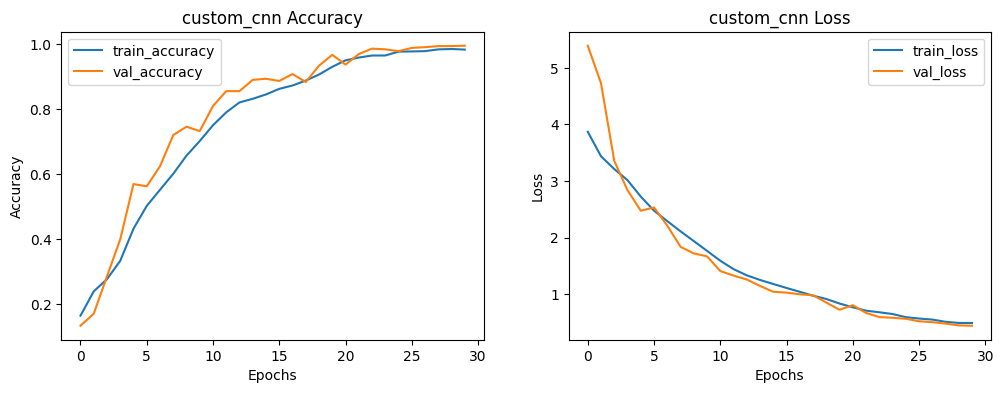

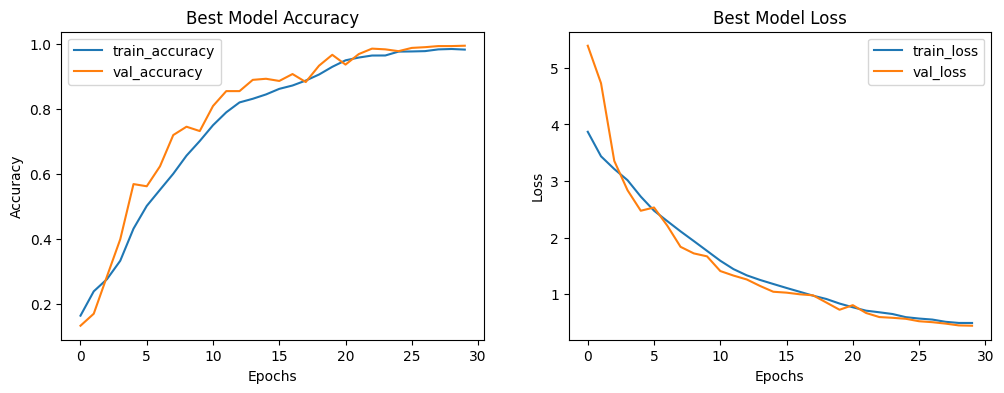

In [ ]:
plot_history(history_custom, 'custom_cnn')
#plot_history(history_cnnWithReg, 'cnn_with_regularization Model')
#plot_history(history_ResNet50, 'resnet50')
plot_history(best_history, 'Best Model')

In [ ]:
# Función para evaluar el modelo
def evaluate_model(model, X_test, y_test, class_names):
    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Métricas de clasificación
    report = classification_report(y_true, y_pred_classes, target_names=class_names)
    cm = confusion_matrix(y_true, y_pred_classes)

    print("Classification Report:\n", report)

    # Matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    return report, cm

In [ ]:
# Función para evaluar el modelo y medir el tiempo de predicción
def evaluate_model(model, class_names):
    # Predicciones
    start_time = time.time()
    prediction_time = time.time() - start_time

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Métricas de clasificación
    report = classification_report(y_true, y_pred_classes, target_names=class_names)
    cm = confusion_matrix(y_true, y_pred_classes)

    print("Classification Report:\n", report)
    print(f"Tiempo de predicción: {prediction_time:.2f} segundos")

    # Matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    return report, cm, prediction_time

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report:
                    precision    recall  f1-score   support

camiseta_amarilla       1.00      0.99      1.00       263
    camiseta_azul       1.00      0.99      0.99       278
  camiseta_blanca       0.98      1.00      0.99       287
    camiseta_roja       1.00      1.00      1.00       283
     vestido_rojo       1.00      1.00      1.00       291
     vestido_azul       1.00      1.00      1.00       288
 vestido_amarillo       0.98      1.00      0.99       282
   vestido_blanco       1.00      0.98      0.99       268

         accuracy                           0.99      2240
        macro avg       0.99      0.99      0.99      2240
     weighted avg       0.99      0.99      0.99      2240

Tiempo de predicción: 0.00 segundos


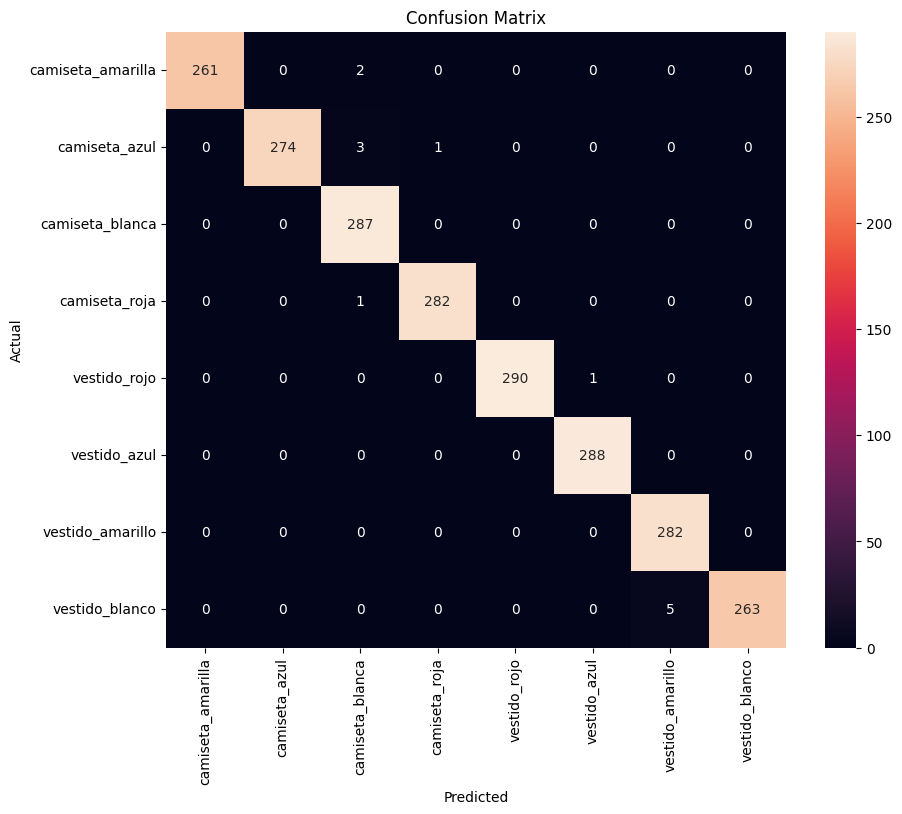

Tiempo de predicción: 2.384185791015625e-07 segundos


In [ ]:
# Evaluar el mejor modelo con los datos de prueba
report, cm, prediction_time = evaluate_model(best_model, class_names)

# Mostrar el tiempo de entrenamiento
print(f"Tiempo de predicción: {prediction_time} segundos")

In [ ]:
# Guardar el modelo entrenado
#model.save('cnn_custom.h5')

import tensorflow as tf

# Asumiendo que tu modelo está guardado en la variable `model`
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Guardar el modelo en formato .tflite
with open('cnn_custom.tflite', 'wb') as f:
    f.write(tflite_model)

print("Modelo guardado en formato .tflite")


Saved artifact at '/tmp/tmp64n1vj7v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_20')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  135802011071264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802011073552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802011072496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802011070032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802011073904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802011895584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802011069856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802011069680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802011895408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135802011899456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13580201189

In [ ]:
from google.colab import files

# Descargar el modelo guardado
files.download('cnn_custom.tflite')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# Subir la imagen
uploaded = files.upload()


Saving 1 (6).jpg to 1 (6).jpg


Saving VestidoRojo.jpg to VestidoRojo (1).jpg
VestidoRojo (1).jpg


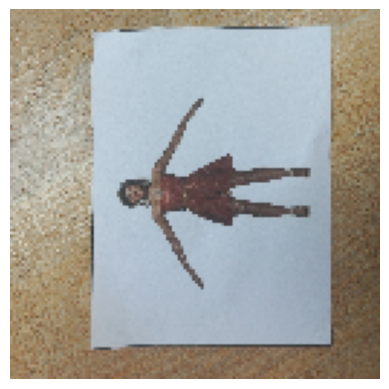

Clase predicha: Clase 4


In [ ]:
# prompt: un codigo que me permita probar el modelo

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
import matplotlib.pyplot as plt

# Cargar el modelo TFLite
interpreter = tf.lite.Interpreter(model_path='cnn_custom.tflite')
interpreter.allocate_tensors()

# Obtener detalles de los tensores
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Subir la imagen
uploaded = files.upload()

# Asume que estas son las clases de tu modelo
class_names = ['Clase 0', 'Clase 1', 'Clase 2','Clase 3','Clase 4','Clase 5','Clase 6','Clase 7']  # Cambia esto según tus clases

for fn in uploaded.keys():
    # Predecir la imagen
    path = fn
    img = load_img(path, target_size=(128, 128))  # Ajusta el tamaño según tu modelo
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Normalizar la imagen

    # Preparar la entrada para el modelo TFLite
    interpreter.set_tensor(input_details[0]['index'], x)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]['index'])

    # Mostrar resultados
    print(fn)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]
    print(f"Clase predicha: {predicted_class}")


Saving VestidoRojo.jpg to VestidoRojo (2).jpg
Archivo: VestidoRojo (2).jpg


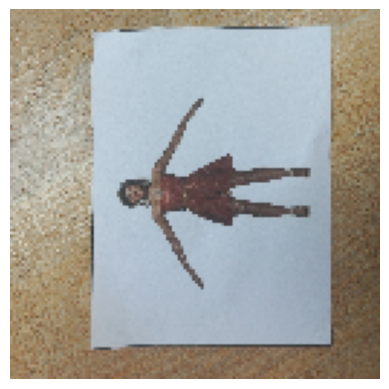

Clase predicha: Clase 4, Probabilidad: 0.95


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
import matplotlib.pyplot as plt

# Cargar el modelo TFLite
interpreter = tf.lite.Interpreter(model_path='cnn_custom.tflite')
interpreter.allocate_tensors()

# Obtener detalles de los tensores
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Subir la imagen
uploaded = files.upload()

# Clases del modelo
class_names = ['Clase 0', 'Clase 1', 'Clase 2', 'Clase 3', 'Clase 4', 'Clase 5', 'Clase 6', 'Clase 7']

for fn in uploaded.keys():
    # Predecir la imagen
    path = fn
    img = load_img(path, target_size=(128, 128))  # Ajusta el tamaño según tu modelo
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Normalizar la imagen

    # Preparar la entrada para el modelo TFLite
    interpreter.set_tensor(input_details[0]['index'], x)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_details[0]['index'])

    # Mostrar resultados
    print(f"Archivo: {fn}")
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Obtener la clase con mayor probabilidad
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]

    print(f"Clase predicha: {predicted_class_name}, Probabilidad: {predicted_probability:.2f}")


In [ ]:
img = load_img('/content/VestidoRojo.jpg', target_size=(128, 128))
x = img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0  # Normalizar

interpreter.set_tensor(input_details[0]['index'], x)
interpreter.invoke()
predictions = interpreter.get_tensor(output_details[0]['index'])
print("Predicciones:", predictions)


Predicciones: [[3.1366083e-06 7.5136154e-07 1.3064708e-08 1.4028456e-07 9.5259511e-01
  9.7458450e-09 4.6503257e-02 8.9759653e-04]]
